# Outlier detection performance as function of training data purity (% inliers)

In [24]:
# import PyOD detector
from pyod.models.knn import KNN
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.semi_supervised import LabelPropagation

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt


In [26]:
datasets = ['1_ALOI', '2_annthyroid', '3_backdoor', '4_breastw', '5_campaign', '6_cardio', '7_Cardiotocography',
            '8_celeba', '9_census', '10_cover', '11_donors', '12_fault', '13_fraud', '14_glass', '15_Hepatitis',
            '16_http', '17_InternetAds', '18_Ionosphere', '19_landsat', '20_letter', '21_Lymphography',
             '22_magic.gamma', '23_mammography', '24_mnist', '25_musk', '26_optdigits', '27_PageBlocks',
             '28_pendigits', '29_Pima', '30_satellite', '31_satimage-2', '32_shuttle', '33_skin',
             '34_smtp', '35_SpamBase', '36_speech', '37_Stamps', '38_thyroid', '39_vertebral',
             '40_vowels', '41_Waveform', '42_WBC', '43_WDBC', '44_Wilt', '45_wine', '46_WPBC', '47_yeast']


In [28]:
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.sod import SOD
from pyod.models.copod import COPOD
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from pyod.models.kde import KDE
from pyod.models.cblof import CBLOF

model_dict = {
    'PCA': PCA,
    'OCSVM': OCSVM,
    'LOF': LOF,
    'COF': COF,
    'HBOS': HBOS,
    'KNN': KNN,
    'SOD': SOD,
    'COPOD': COPOD,
    'ECOD': ECOD,
    'IForest': IForest,
    'LODA': LODA,
    'KDE': KDE,
    'CBLOF': CBLOF
}

# Test pipeline with one dataset

In [31]:
dataset = '33_skin'
path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
data = np.load(path, allow_pickle=True)
X, y = data['X'], data['y']

In [33]:
num_samples = 1000  # total samples including training and testing
reps = range(5)

random_state = 42

# get samples from dataset
samp_frac = num_samples / np.shape(X)[0]

# vary fraction outliers to remove from training data
fractions = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

model_names = ['IForest']

all_results = pd.DataFrame()

for frac in fractions:
    for model_name in model_names:
        for rep in reps:
            _, Xsamp, _, ysamp = train_test_split(X, y, test_size=samp_frac,
                                                    random_state=rep,
                                                    stratify=y)

            # split samples into training and testing
            X_train, X_test, y_train, y_test = train_test_split(Xsamp, ysamp, test_size=0.5,
                                                                random_state=rep,
                                                                stratify=ysamp)
            # remove outliers from training data
            if frac > 0:
                # get indices of outliers
                idx = np.where(y_train == 1)[0]
                # shuffle indices
                np.random.shuffle(idx)
                # calculate number of outliers to remove
                num_outliers = int(frac * len(idx))
                # remove outliers
                X_train = np.delete(X_train, idx[:num_outliers], axis=0)
                y_train = np.delete(y_train, idx[:num_outliers])

            # train model
            detector = model_dict[model_name]()
            detector.fit(X_train)

            # get outlier scores
            X_test_scores = detector.decision_function(X_test)

            # calculate auc roc
            roc_auc = roc_auc_score(y_test, X_test_scores)
            # print(f'{dataset}, {frac}, {rep}, {roc_auc}')

            result = {'dataset': dataset, 'num_samples': len(ysamp), 'model': model_name, 'roc_auc': roc_auc, 'fraction': frac, 'rep': rep}
            result_df = pd.DataFrame(result, index=[0])
            
            all_results = pd.concat([all_results, result_df])



/var/folders/cw/5n__wtss1mn3kzz7j7fm7wfh0000gn/T/ipykernel_930/2911128732.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.0f}'.format(x*100) for x in fractions])


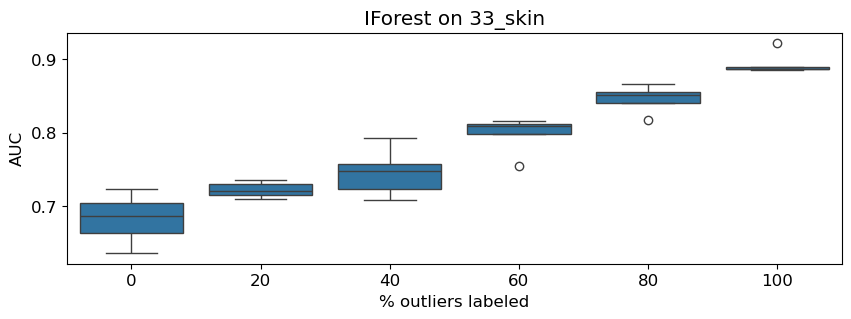

In [34]:
# plot box plot showing auc roc for each fraction of outliers removed
plt.figure(figsize=(10, 3))
sns.boxplot(x='fraction', y='roc_auc', data=all_results)
plt.title(f'{model_name} on {dataset}')
plt.ylabel('AUC')
plt.xlabel(f'% outliers labeled')
# format x tick labels as percentage
plt.gca().set_xticklabels(['{:.0f}'.format(x*100) for x in fractions])
plt.show()

# Test pipeline on all datasets

In [37]:
num_samples = 1000  # total samples including training and testing
reps = range(5)

# get samples from dataset
samp_frac = num_samples / np.shape(X)[0]

# vary fraction outliers to remove from training data
fractions = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

model_names = ['IForest', 'KNN']

all_datsets_results = pd.DataFrame()

dataset_subset = ['33_skin']

dataset_subset = ['2_annthyroid', '5_campaign', '6_cardio', '7_Cardiotocography', '9_census',
             '11_donors', '12_fault', '15_Hepatitis', '18_Ionosphere', '19_landsat', '20_letter', 
             '22_magic.gamma', '24_mnist', '27_PageBlocks', '29_Pima', '30_satellite', '32_shuttle',
             '35_SpamBase']

for dataset in tqdm(datasets):
    try:
        # print dataset
        print(f'Processing {dataset}')
        path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
        data = np.load(path, allow_pickle=True)
        X, y = data['X'], data['y']

        # get samples from dataset
        samp_frac = num_samples / np.shape(X)[0]
        if samp_frac > 1:
            samp_frac = 1

        for frac in fractions:
            for model_name in model_names:
                for rep in reps:
                    _, Xsamp, _, ysamp = train_test_split(X, y, test_size=samp_frac,
                                                            random_state=random_state,
                                                            stratify=y)

                    # split samples into training and testing
                    X_train, X_test, y_train, y_test = train_test_split(Xsamp, ysamp, test_size=0.5,
                                                                        random_state=random_state,
                                                                        stratify=ysamp)
                    # remove outliers from training data
                    if frac > 0:
                        # get indices of outliers
                        idx = np.where(y_train == 1)[0]
                        # shuffle indices
                        np.random.shuffle(idx)
                        # calculate number of outliers to remove
                        num_outliers = int(frac * len(idx))
                        # remove outliers
                        X_train = np.delete(X_train, idx[:num_outliers], axis=0)
                        y_train = np.delete(y_train, idx[:num_outliers])

                    # train model
                    detector = model_dict[model_name]()
                    detector.fit(X_train)

                    # get outlier scores
                    X_test_scores = detector.decision_function(X_test)

                    # calculate auc roc
                    roc_auc = roc_auc_score(y_test, X_test_scores)
                    # print(f'{dataset}, {frac}, {rep}, {roc_auc}')

                    result = {'dataset': dataset, 'num_samples': len(ysamp), 'model': model_name, 'roc_auc': roc_auc, 'fraction': frac, 'rep': rep}
                    result_df = pd.DataFrame(result, index=[0])
                    
                    all_datsets_results = pd.concat([all_datsets_results, result_df])

    except Exception as e:
        print(f'Error processing {dataset}: {e}')

  0%|                                                    | 0/47 [00:00<?, ?it/s]

Processing 1_ALOI


  2%|▉                                           | 1/47 [00:13<10:03, 13.12s/it]

Processing 2_annthyroid


  4%|█▊                                          | 2/47 [00:25<09:22, 12.50s/it]

Processing 3_backdoor


  6%|██▊                                         | 3/47 [01:11<20:20, 27.74s/it]

Processing 4_breastw
Error processing 4_breastw: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 5_campaign


 11%|████▋                                       | 5/47 [01:30<12:21, 17.66s/it]

Processing 6_cardio


 13%|█████▌                                      | 6/47 [01:40<10:32, 15.43s/it]

Processing 7_Cardiotocography


 15%|██████▌                                     | 7/47 [01:51<09:17, 13.95s/it]

Processing 8_celeba


 17%|███████▍                                    | 8/47 [02:13<10:41, 16.45s/it]

Processing 9_census


 19%|███████▊                                 | 9/47 [08:59<1:23:26, 131.74s/it]

Processing 10_cover


 21%|████████▌                               | 10/47 [09:32<1:03:05, 102.31s/it]

Processing 11_donors


 23%|██████████                                 | 11/47 [10:08<49:29, 82.49s/it]

Processing 12_fault


 26%|██████████▉                                | 12/47 [10:22<36:13, 62.11s/it]

Processing 13_fraud


 28%|███████████▉                               | 13/47 [10:51<29:30, 52.08s/it]

Processing 14_glass
Error processing 14_glass: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 15_Hepatitis
Error processing 15_Hepatitis: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 16_http


 34%|██████████████▋                            | 16/47 [11:27<15:18, 29.64s/it]

Processing 17_InternetAds


 36%|███████████████▌                           | 17/47 [12:10<16:13, 32.44s/it]

Processing 18_Ionosphere
Error processing 18_Ionosphere: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 19_landsat


 40%|█████████████████▍                         | 19/47 [12:28<11:01, 23.61s/it]

Processing 20_letter


 43%|██████████████████▎                        | 20/47 [12:45<09:58, 22.16s/it]

Processing 21_Lymphography
Error processing 21_Lymphography: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 22_magic.gamma


 47%|████████████████████▏                      | 22/47 [13:01<07:02, 16.91s/it]

Processing 23_mammography


 49%|█████████████████████                      | 23/47 [13:17<06:41, 16.73s/it]

Processing 24_mnist


 51%|█████████████████████▉                     | 24/47 [13:35<06:29, 16.94s/it]

Processing 25_musk


 53%|██████████████████████▊                    | 25/47 [13:49<05:58, 16.30s/it]

Processing 26_optdigits


 55%|███████████████████████▊                   | 26/47 [14:01<05:15, 15.04s/it]

Processing 27_PageBlocks


 57%|████████████████████████▋                  | 27/47 [14:12<04:42, 14.11s/it]

Processing 28_pendigits


 60%|█████████████████████████▌                 | 28/47 [14:26<04:28, 14.14s/it]

Processing 29_Pima
Error processing 29_Pima: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 30_satellite


 64%|███████████████████████████▍               | 30/47 [14:40<03:03, 10.80s/it]

Processing 31_satimage-2


 66%|████████████████████████████▎              | 31/47 [14:51<02:54, 10.93s/it]

Processing 32_shuttle


 68%|█████████████████████████████▎             | 32/47 [15:03<02:45, 11.07s/it]

Processing 33_skin


 70%|██████████████████████████████▏            | 33/47 [15:21<03:00, 12.91s/it]

Processing 34_smtp


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaco

Processing 35_SpamBase


 74%|████████████████████████████████           | 35/47 [15:45<02:29, 12.42s/it]

Processing 36_speech


 77%|████████████████████████████████▉          | 36/47 [16:00<02:24, 13.16s/it]

Processing 37_Stamps
Error processing 37_Stamps: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 38_thyroid


 81%|██████████████████████████████████▊        | 38/47 [16:08<01:20,  8.99s/it]

Processing 39_vertebral
Error processing 39_vertebral: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 40_vowels


 85%|████████████████████████████████████▌      | 40/47 [16:16<00:49,  7.05s/it]

Processing 41_Waveform


 87%|█████████████████████████████████████▌     | 41/47 [16:24<00:43,  7.24s/it]

Processing 42_WBC
Error processing 42_WBC: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 43_WDBC
Error processing 43_WDBC: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 44_Wilt


 94%|████████████████████████████████████████▎  | 44/47 [16:32<00:15,  5.04s/it]

Processing 45_wine
Error processing 45_wine: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 46_WPBC
Error processing 46_WPBC: The test_size = 1 should be greater or equal to the number of classes = 2
Processing 47_yeast


100%|███████████████████████████████████████████| 47/47 [16:40<00:00, 21.28s/it]


In [38]:
# average data over repeats
all_datsets_mn_results = all_datsets_results.groupby(['dataset', 'model', 'fraction']).mean().reset_index()

# calculate difference in auc roc between 0% and 100% outliers for KNN model on each dataset
dataset_dif = {}
for dataset in datasets:
    try:
        dataset_dif[dataset] = all_datsets_mn_results[(all_datsets_mn_results['dataset'] == dataset) & (all_datsets_mn_results['fraction'] == 1.0) & (all_datsets_mn_results['model'] == 'KNN')]['roc_auc'].values[0] - all_datsets_mn_results[(all_datsets_mn_results['dataset'] == dataset) & (all_datsets_mn_results['fraction'] == 0.0) & (all_datsets_mn_results['model'] == 'KNN')]['roc_auc'].values[0]
    except:
        pass

In [39]:
# get list of datasets sorted by difference in auc roc between 0% and 100% outliers for KNN model
datasets_sorted_by_dif = sorted(dataset_dif, key=dataset_dif.get, reverse=True)
datasets_sorted_by_dif

['26_optdigits',
 '33_skin',
 '11_donors',
 '6_cardio',
 '28_pendigits',
 '7_Cardiotocography',
 '32_shuttle',
 '30_satellite',
 '19_landsat',
 '25_musk',
 '10_cover',
 '22_magic.gamma',
 '34_smtp',
 '44_Wilt',
 '24_mnist',
 '47_yeast',
 '17_InternetAds',
 '12_fault',
 '9_census',
 '41_Waveform',
 '27_PageBlocks',
 '35_SpamBase',
 '20_letter',
 '23_mammography',
 '40_vowels',
 '5_campaign',
 '38_thyroid',
 '2_annthyroid',
 '36_speech',
 '1_ALOI',
 '31_satimage-2',
 '3_backdoor',
 '13_fraud',
 '16_http',
 '8_celeba']

/var/folders/cw/5n__wtss1mn3kzz7j7fm7wfh0000gn/T/ipykernel_930/2494932918.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.0f}'.format(x*100) for x in fractions])


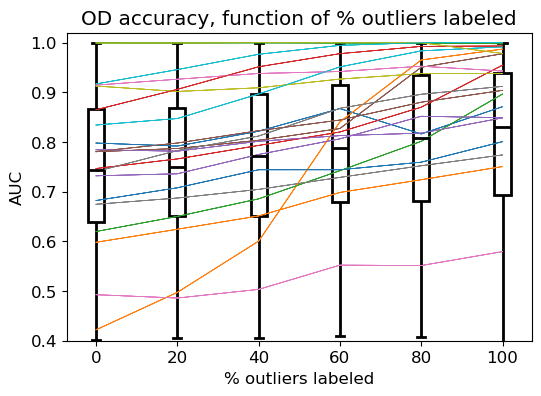

In [40]:
# average data over repeats
all_datsets_mn_results = all_datsets_results.groupby(['dataset', 'model', 'fraction']).mean().reset_index()

# filter results to only include datasets in dataset_subset
dataset_subset = ['33_skin', '2_annthyroid', '5_campaign', '6_cardio', '7_Cardiotocography', '9_census']
dataset_subset = datasets
all_datsets_mn_results = all_datsets_mn_results[all_datsets_mn_results['dataset'].isin(dataset_subset)]

# filter results to only include models in model_subset
model_subset = ['IForest']
model_subset = ['KNN']
model_subset = ['IForest', 'KNN']
all_datsets_mn_results = all_datsets_mn_results[all_datsets_mn_results['model'].isin(model_subset)]

# set mpl font size
plt.rcParams.update({'font.size': 12})

# get list of datasets with greatest difference in auc roc between 0 and 1 fraction outliers


# plot box plot showing auc roc for each fraction of outliers removed
plt.figure(figsize=(6, 4))
sns.boxplot(x='fraction', y='roc_auc', data=all_datsets_mn_results, width=0.2, color='w',
            linewidth=2, linecolor='k')

# plot data connecting lines for each dataset
dataset_subset = ['33_skin', '2_annthyroid', '5_campaign', '6_cardio', '7_Cardiotocography', '9_census']
dataset_subset = datasets_sorted_by_dif[:10]
frac_data = {}
for dataset in dataset_subset:
    frac_data[dataset] = []
    for frac in fractions:
        data = all_datsets_mn_results[(all_datsets_mn_results['dataset'] == dataset) & (all_datsets_mn_results['fraction'] == frac)]
        frac_data[dataset].append(data['roc_auc'].values)
        
for frac in fractions[:-1]:
    for dataset in dataset_subset:
        plt.plot(np.arange(len(fractions)), frac_data[dataset], label=dataset,
                 linewidth=0.5)

plt.title(f'OD accuracy, function of % outliers labeled')
plt.ylabel('AUC')
plt.ylim(0.4, 1.02)
plt.xlabel(f'% outliers labeled')
# format x tick labels as percentage
plt.gca().set_xticklabels(['{:.0f}'.format(x*100) for x in fractions])
plt.show()

# Add label diffusion

## Test on one dataset

In [43]:
dataset = '33_skin'
path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
data = np.load(path, allow_pickle=True)
X, y = data['X'], data['y']

### Test label propagation

In [45]:
num_samples = 1000  # total samples including training and testing
random_state = 42

# get samples from dataset
samp_frac = num_samples / np.shape(X)[0]
fraction = .05  # fraction of true labels to work with
model_name = 'IForest'

_, Xsamp, _, ysamp = train_test_split(X, y, test_size=samp_frac,
                                                    random_state=rep,
                                                    stratify=y)

# split samples into training and testing
X_train, X_test, y_train, y_test = train_test_split(Xsamp, ysamp, test_size=0.5,
                                                                random_state=random_state,
                                                                stratify=ysamp)

if fraction > 0:
    label_prop_model = LabelPropagation()

    rng = np.random.RandomState(42)
    random_unlabeled_points = rng.rand(len(y_train)) > fraction
    labels = np.copy(y_train)
    labels[random_unlabeled_points] = -1
    label_prop_model.fit(X_train, labels)

    label_proba = label_prop_model.predict_proba(X_train)

    # make vector of uniform random values
    random_values = rng.rand(len(y_train))

    # remove outliers from training data
    remove_idx_prop = np.where(label_proba[:,0] < random_values)[0]
    X_train_prop = np.delete(X_train, remove_idx_prop, axis=0)
    y_train_prop = np.delete(y_train, remove_idx_prop)

    remove_idx_noprop = np.where(labels > -1)[0]
    X_train_noprop = np.delete(X_train, remove_idx_noprop, axis=0)
    y_train_noprop = np.delete(y_train, remove_idx_noprop)

# train model
detector = model_dict[model_name]()
detector.fit(X_train_prop)

# get outlier scores
X_test_scores = detector.decision_function(X_test)

# calculate auc roc
roc_auc = roc_auc_score(y_test, X_test_scores)
print(f'{roc_auc}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


0.9066556868823872


### Evaluate for different fractions of labels

In [47]:
int(0.03 * len(idx))

5

In [48]:
num_samples = 1000  # total samples including training and testing
reps = range(5)

random_state = 42

# get samples from dataset
samp_frac = num_samples / np.shape(X)[0]

# vary fraction outliers to remove from training data
fractions = [0, 0.005, 0.008, 0.01, 0.013, 0.02, 0.03, 0.06,
             0.1, 0.15, 0.2, 0.3, 0.45, 0.7, 1.0]

model_names = ['IForest']

all_results_prop = pd.DataFrame()
all_results_noprop = pd.DataFrame()

for frac in tqdm(fractions):
    for model_name in model_names:
        for rep in reps:
            _, Xsamp, _, ysamp = train_test_split(X, y, test_size=samp_frac,
                                                    random_state=rep,
                                                    stratify=y)

            # split samples into training and testing
            X_train, X_test, y_train, y_test = train_test_split(Xsamp, ysamp, test_size=0.5,
                                                                random_state=rep,
                                                                stratify=ysamp)
            # remove outliers from training data
            idx = np.arange(len(y_train))

            rng = np.random.RandomState(rep)
            rng.shuffle(idx)
            # calculate number of labels to query
            num_labels = int(frac * len(idx))

            if num_labels > 0:
                labels = np.copy(y_train)
                labels[idx[num_labels:]] = -1  # set unqueried labels to -1

                label_prop_model = LabelPropagation()

                label_prop_model.fit(X_train, labels)

                label_proba = label_prop_model.predict_proba(X_train)

                # make vector of uniform random values
                random_values = rng.rand(len(y_train))

                # remove outliers from training data
                remove_idx_prop = np.where(label_proba[:,0] < random_values)[0]
                X_train_prop = np.delete(X_train, remove_idx_prop, axis=0)
                y_train_prop = np.delete(y_train, remove_idx_prop)

                remove_idx_noprop = np.where(labels == 1)[0]
                X_train_noprop = np.delete(X_train, remove_idx_noprop, axis=0)
                y_train_noprop = np.delete(y_train, remove_idx_noprop)
            else:
                X_train_prop = X_train
                y_train_prop = y_train

                X_train_noprop = X_train
                y_train_noprop = y_train

            # train model
            detector_prop = model_dict[model_name]()
            detector_noprop = model_dict[model_name]()

            detector_prop.fit(X_train_prop)
            detector_noprop.fit(X_train_noprop)

            # get outlier scores
            X_test_scores_prop = detector_prop.decision_function(X_test)
            X_test_scores_noprop = detector_noprop.decision_function(X_test)

            # calculate auc roc
            roc_auc_prop = roc_auc_score(y_test, X_test_scores_prop)
            roc_auc_noprop = roc_auc_score(y_test, X_test_scores_noprop)

            result_prop = {'dataset': dataset, 'num_samples': len(ysamp), 'model': model_name, 'roc_auc': roc_auc_prop, 'fraction': frac, 'rep': rep}
            result_df_prop = pd.DataFrame(result_prop, index=[0])
            
            all_results_prop = pd.concat([all_results_prop, result_df_prop])

            result_noprop = {'dataset': dataset, 'num_samples': len(ysamp), 'model': model_name, 'roc_auc': roc_auc_noprop, 'fraction': frac, 'rep': rep}
            result_df_noprop = pd.DataFrame(result_noprop, index=[0])
            
            all_results_noprop = pd.concat([all_results_noprop, result_df_noprop])



  7%|██▉                                         | 1/15 [00:02<00:34,  2.43s/it]/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
 13%|█████▊                                      | 2/15 [00:05<00:35,  2.74s/it]/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=

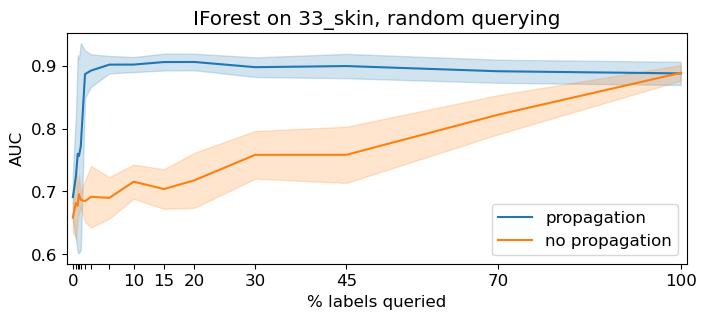

In [49]:
# plot line plot showing auc roc for each fraction of outliers removed with uncertainty
plt.figure(figsize=(8, 3))
sns.lineplot(x='fraction', y='roc_auc', data=all_results_prop, errorbar='sd', label='propagation')
sns.lineplot(x='fraction', y='roc_auc', data=all_results_noprop, errorbar='sd', label='no propagation')
plt.title(f'{model_name} on {dataset}, random querying')
plt.ylabel('AUC')
plt.xlabel(f'% labels queried')

# format x tick labels as percentage
ax = plt.gca()
ax.set_xticks(fractions)
plt.gca().set_xticklabels(['{:.0f}'.format(x*100) if x >= 0.1 or x == 0 else '' for x in fractions])

plt.xlim(-.01, 1.01)

plt.show()



In [50]:
# plot line plot showing auc roc for each fraction of outliers removed with uncertainty
# make broken x axis to represent 0 by itself, and 0.01 to 1 on log scale
plt.figure(figsize=(8, 3))

# compute mean and std for each fraction
mean_results_prop = all_results_prop.groupby('fraction').mean().reset_index()
std_results_prop = all_results_prop.groupby('fraction').std().reset_index()
mean_results_noprop = all_results_noprop.groupby('fraction').mean().reset_index()
std_results_noprop = all_results_noprop.groupby('fraction').std().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(8, 3), width_ratios=[1, 8])
fig.subplots_adjust(wspace=0.05)  # adjust space between Axes
ax1.errorbar(mean_results_prop['fraction'][0], mean_results_prop['roc_auc'][0], yerr=std_results_prop['roc_auc'][0], label='propagation', marker='o')
ax1.errorbar(mean_results_noprop['fraction'][0],mean_results_noprop['roc_auc'][0],yerr=std_results_noprop['roc_auc'][0], label='no prop.', marker='o')

ax2.plot(mean_results_prop['fraction'], mean_results_prop['roc_auc'], label='propagation')
ax2.fill_between(mean_results_prop['fraction'], mean_results_prop['roc_auc']-std_results_prop['roc_auc'], mean_results_prop['roc_auc']+std_results_prop['roc_auc'], alpha=0.2)
ax2.plot(mean_results_noprop['fraction'], mean_results_noprop['roc_auc'], label='no prop.')
ax2.fill_between(mean_results_noprop['fraction'], mean_results_noprop['roc_auc']-std_results_noprop['roc_auc'], mean_results_noprop['roc_auc']+std_results_noprop['roc_auc'], alpha=0.2)

# zoom-in / limit the view to different portions of the data
ax1.set_xlim(-0.01, 0.01)  # outliers only
ax2.set_xlim(0.01, 1)  # most of the data

# hide spines between ax and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
# hide other spines
# ax1.spines.top.set_visible(False)
# ax1.spines.right.set_visible(False)
# ax2.spines.top.set_visible(False)
# ax2.spines.right.set_visible(False)

d = 2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
# turn off the spines and remove ticks and labels for ax2
ax2.yaxis.set_visible(False)

plt.xscale('log')
plt.gca().set_xticklabels(['{:g}'.format(x*100) for x in fractions[1:]])
ax2.set_xticks(fractions[1:])
ax2.set_xticks([], minor=True)

ax1.set_xticks([0])
plt.xlim(fractions[1], 1.01)

plt.title(f'{model_name} on {dataset}, random querying')
ax1.set_ylabel('AUC')
plt.xlabel(f'% labels queried')

plt.show()

TypeError: agg function failed [how->mean,dtype->object]

<Figure size 800x300 with 0 Axes>

# Active Learning - define query strategies

In [51]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

def query_labels(X, y, detector,
                 queried_labels=None, strategy='random',
                 num_labels=1, random_state=42):
    
    if queried_labels is None:  # initialize all labels as unqueried (-1)
        queried_labels = np.zeros(len(y)) - 1

    idx_unqueried = np.where(queried_labels == -1)[0]
    
    if strategy == 'random':
        rng = np.random.default_rng(random_state)
        idx_random = rng.permuted(idx_unqueried)
        queried_labels[idx_random[:num_labels]] = y[idx_random[:num_labels]]

    elif strategy == 'uncertainty':
        # get outlier confidence
        confidence = detector.predict_confidence(X[idx_unqueried,:])
        # sort by confidence
        idx_confidence = np.argsort(confidence)
        queried_labels[idx_confidence[:num_labels]] = y[idx_confidence[:num_labels]]

    elif strategy == 'anomalous':
        # get outlier scores
        scores = detector.decision_function(X[idx_unqueried,:])
        # sort by decreasing outlier score
        idx_scores = np.argsort(scores)[::-1]
        queried_labels[idx_scores[:num_labels]] = y[idx_scores[:num_labels]]

    elif strategy == 'clusters':
        # get clusters
        clust = AgglomerativeClustering(n_clusters=num_labels)
        clust_labels = clust.fit_predict(X[idx_unqueried,:])
        # for each cluster, get the medoid
        for i in range(num_labels):
            idx_cluster = np.where(clust_labels == i)[0]
            dist_mat = pairwise_distances(X[idx_cluster,:])
            medoid_index = np.argmin(dist_mat.sum(axis=1))
            queried_labels[idx_cluster[medoid_index]] = y[idx_cluster[medoid_index]]

    return queried_labels

import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

def query_labels(X, y, detector,
                 queried_labels=None, strategy='random',
                 num_labels=1, random_state=42):

    if queried_labels is None:  # initialize all labels as unqueried (-1)
        queried_labels = np.full(len(y), -1)

    idx_unqueried = np.where(queried_labels == -1)[0]
    
    if len(idx_unqueried) == 0:
        return queried_labels  # No unqueried samples left

    if strategy == 'random':
        rng = np.random.default_rng(random_state)
        idx_random = rng.permuted(idx_unqueried)[:num_labels]
        queried_labels[idx_random] = y[idx_random]

    elif strategy == 'uncertainty':
        confidence = detector.predict_confidence(X[idx_unqueried, :])
        idx_confidence = np.argsort(confidence)[:num_labels]  # Lowest confidence
        queried_labels[idx_unqueried[idx_confidence]] = y[idx_unqueried[idx_confidence]]

    elif strategy == 'anomalous':
        scores = detector.decision_function(X[idx_unqueried, :])
        idx_scores = np.argsort(scores)[::-1][:num_labels]  # Highest anomaly scores
        queried_labels[idx_unqueried[idx_scores]] = y[idx_unqueried[idx_scores]]

    elif strategy == 'clusters':
        clust = AgglomerativeClustering(n_clusters=num_labels)
        clust_labels = clust.fit_predict(X[idx_unqueried, :])
        for i in range(num_labels):
            idx_cluster = np.where(clust_labels == i)[0]
            dist_mat = pairwise_distances(X[idx_unqueried[idx_cluster], :])
            medoid_index = np.argmin(dist_mat.sum(axis=1))
            queried_labels[idx_unqueried[idx_cluster[medoid_index]]] = y[idx_unqueried[idx_cluster[medoid_index]]]

    elif strategy == 'diversity':
        kmeans = KMeans(n_clusters=num_labels, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(X[idx_unqueried, :])
        cluster_centers = kmeans.cluster_centers_
        idx_diverse = []
        for center in cluster_centers:
            dist = np.linalg.norm(X[idx_unqueried, :] - center, axis=1)
            idx_diverse.append(idx_unqueried[np.argmin(dist)])  # Closest to centroid
        queried_labels[idx_diverse] = y[idx_diverse]

    elif strategy == 'density_uncertainty':
        confidence = detector.predict_confidence(X[idx_unqueried, :])
        nbrs = NearestNeighbors(n_neighbors=5).fit(X[idx_unqueried, :])
        density = np.mean(nbrs.kneighbors(X[idx_unqueried, :], return_distance=True)[0], axis=1)
        scores = -confidence * density  # Low confidence & high density
        idx_density = np.argsort(scores)[:num_labels]
        queried_labels[idx_unqueried[idx_density]] = y[idx_unqueried[idx_density]]

    elif strategy == 'core_set':
        kmeans = KMeans(n_clusters=num_labels, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(X[idx_unqueried, :])
        cluster_centers = kmeans.cluster_centers_
        idx_core = []
        for center in cluster_centers:
            idx_core.append(idx_unqueried[np.argmin(np.linalg.norm(X[idx_unqueried, :] - center, axis=1))])
        queried_labels[idx_core] = y[idx_core]

    elif strategy == 'expected_model_change':
        scores = detector.decision_function(X[idx_unqueried, :])
        idx_highest = np.argsort(scores)[-num_labels:]  # Largest expected change
        queried_labels[idx_unqueried[idx_highest]] = y[idx_unqueried[idx_highest]]

    elif strategy == 'uncertainty_clusters':
        confidence = detector.predict_confidence(X[idx_unqueried, :])
        uncertain_idx = np.argsort(confidence)[:num_labels * 2]
        subset = X[idx_unqueried[uncertain_idx], :]
        clust = AgglomerativeClustering(n_clusters=num_labels)
        clust_labels = clust.fit_predict(subset)
        idx_final = []
        for i in range(num_labels):
            idx_cluster = np.where(clust_labels == i)[0]
            dist_mat = pairwise_distances(subset[idx_cluster, :])
            medoid_index = np.argmin(dist_mat.sum(axis=1))
            idx_final.append(idx_unqueried[uncertain_idx[idx_cluster[medoid_index]]])
        queried_labels[idx_final] = y[idx_final]

    return queried_labels


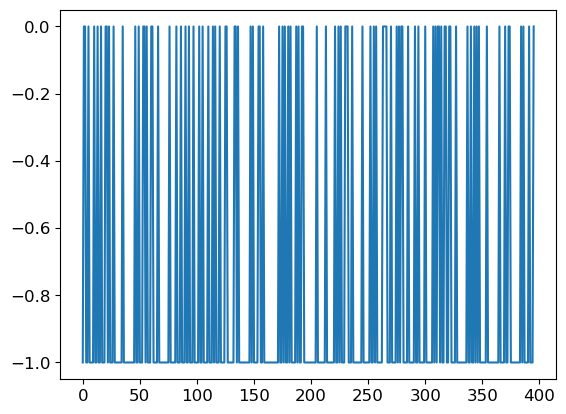

In [64]:
queried_labels = query_labels(X_train, y_train, detector,
                              queried_labels=None, strategy='clusters',
                              num_labels=100)

plt.plot(queried_labels)
plt.show()

## Compare random vs uncertainty querying

In [56]:
num_samples = 1000  # total samples including training and testing
reps = range(5)

random_state = 42

# get samples from dataset
samp_frac = num_samples / np.shape(X)[0]

# vary fraction outliers to remove from training data
fractions = [0, 0.004, 0.006, 0.008, 0.01, 0.013, 0.02, 0.03, 0.04, 0.06, 0.08,
             0.1, 0.15, 0.2, 0.3, 0.45, 0.7, 1.0]

# fractions = [0, 0.01, 0.03, 0.1, 0.3, 0.7]

model_names = ['IForest']

query_strategies = ['random', 'uncertainty', 'anomalous', 'clusters']
propagations = [True, False]

all_results = pd.DataFrame()

for frac in tqdm(fractions):
    for model_name in model_names:
        for strategy in query_strategies:
            for propagation in propagations:
                for rep in reps:
                    _, Xsamp, _, ysamp = train_test_split(X, y, test_size=samp_frac,
                                                            random_state=rep,
                                                            stratify=y)

                    # split samples into training and testing
                    X_train, X_test, y_train, y_test = train_test_split(Xsamp, ysamp, test_size=0.5,
                                                                        random_state=rep,
                                                                        stratify=ysamp)
                    idx = np.arange(len(y_train))

                    rng = np.random.RandomState(rep)
                    rng.shuffle(idx)
                    # calculate number of labels to query
                    num_labels = int(frac * len(idx))

                    if num_labels > 0:
                        # get labels using query strategy
                        labels = query_labels(X_train, y_train, detector,
                                                queried_labels=None, strategy=strategy,
                                                num_labels=num_labels)
                        
                        if propagation:

                            label_prop_model = LabelPropagation()

                            label_prop_model.fit(X_train, labels)

                            label_proba = label_prop_model.predict_proba(X_train)

                            # make vector of uniform random values
                            random_values = rng.rand(len(y_train))

                            # remove outliers from training data
                            remove_idx_prop = np.where(label_proba[:,0] < random_values)[0]
                            X_train = np.delete(X_train, remove_idx_prop, axis=0)
                            y_train = np.delete(y_train, remove_idx_prop)

                        else:
                            remove_idx_noprop = np.where(labels == 1)[0]
                            X_train = np.delete(X_train, remove_idx_noprop, axis=0)
                            y_train = np.delete(y_train, remove_idx_noprop)

                    # train model
                    detector = model_dict[model_name]()
                    detector.fit(X_train)

                    # get outlier scores
                    X_test_scores = detector.decision_function(X_test)

                    # calculate auc roc
                    roc_auc = roc_auc_score(y_test, X_test_scores)

                    result = {'dataset': dataset, 'num_samples': len(ysamp),
                              'model': model_name, 'roc_auc': roc_auc,
                              'fraction': frac, 'rep': rep,
                              'query_strategy': strategy, 'propagation': propagation}
                    result_df = pd.DataFrame(result, index=[0])
                    
                    all_results = pd.concat([all_results, result_df])



  6%|██▍                                         | 1/18 [00:12<03:30, 12.39s/it]/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
 11%|████▉                                       | 2/18 [00:27<03:45, 14.12s/it]/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.semi_supervised import LabelPropagation

# Define the total samples (including training & testing)
num_samples = 1000
reps = range(5)
random_state = 42

# Sample fraction based on dataset size
samp_frac = num_samples / np.shape(X)[0]

# Define different fractions of outliers to remove
fractions = [0, 0.004, 0.006, 0.008, 0.01, 0.013, 0.02, 0.03, 0.04, 0.06, 0.08,
             0.1, 0.15, 0.2, 0.3, 0.45, 0.7, 1.0]

# Model and query strategy options
model_names = ['IForest']
query_strategies = ['random', 'uncertainty', 'anomalous', 'clusters', 
                    'diversity', 'density_uncertainty', 'core_set', 
                    'expected_model_change', 'uncertainty_clusters']
propagations = [True, False]

all_results = pd.DataFrame()

# Loop through different experimental settings
for frac in tqdm(fractions):
    for model_name in model_names:
        for strategy in query_strategies:
            for propagation in propagations:
                for rep in reps:
                    # Sample dataset
                    _, Xsamp, _, ysamp = train_test_split(X, y, test_size=samp_frac,
                                                          random_state=rep, stratify=y)

                    # Split into train/test sets
                    X_train, X_test, y_train, y_test = train_test_split(Xsamp, ysamp, test_size=0.5,
                                                                        random_state=rep, stratify=ysamp)

                    # Get shuffled indices for training data
                    idx = np.arange(len(y_train))
                    np.random.RandomState(rep).shuffle(idx)

                    # Determine number of labels to query
                    num_labels = int(frac * len(idx))
                    num_labels = max(1, min(num_labels, len(y_train)))  # Ensure valid range

                    if num_labels > 0:
                        # Query labels based on strategy
                        labels = query_labels(X_train, y_train, detector,
                                              queried_labels=None, strategy=strategy,
                                              num_labels=num_labels)

                        if propagation:
                            # Apply Label Propagation
                            label_prop_model = LabelPropagation()
                            label_prop_model.fit(X_train, labels)

                            label_proba = label_prop_model.predict_proba(X_train)
                            random_values = np.random.RandomState(rep).rand(len(y_train))

                            # Remove uncertain outliers
                            remove_idx_prop = np.where(label_proba[:, 0] < random_values)[0]
                            X_train = np.delete(X_train, remove_idx_prop, axis=0)
                            y_train = np.delete(y_train, remove_idx_prop)
                        else:
                            remove_idx_noprop = np.where(labels == 1)[0]
                            X_train = np.delete(X_train, remove_idx_noprop, axis=0)
                            y_train = np.delete(y_train, remove_idx_noprop)

                    # Train model
                    detector = model_dict[model_name]()
                    detector.fit(X_train)

                    # Compute outlier scores
                    X_test_scores = detector.decision_function(X_test)

                    # Calculate AUC-ROC
                    roc_auc = roc_auc_score(y_test, X_test_scores)

                    # Store results
                    result = {
                        'dataset': dataset, 'num_samples': len(ysamp),
                        'model': model_name, 'roc_auc': roc_auc,
                        'fraction': frac, 'rep': rep,
                        'query_strategy': strategy, 'propagation': propagation
                    }
                    result_df = pd.DataFrame(result, index=[0])
                    all_results = pd.concat([all_results, result_df], ignore_index=True)


In [67]:
# function for plotting results
def plot_ssalad_results(results_df,
                        strategies=None, propagation=None,
                        log_scale=True):
    
    if strategies is None:
        strategies = list(results_df['query_strategy'].unique())

    if propagation is None:
        propagation = list(results_df['propagation'].unique())
    
    num_strategies = len(strategies)
    num_propagation = len(propagation)

    # set colors for each strategy
    colors = sns.color_palette('tab10', num_strategies)
    # set line styles for each propagation
    line_styles = ['-', '--']

    if log_scale and 0 in results_df['fraction'].unique():
        split_axis = True
    else:
        split_axis = False

    if log_scale and split_axis:

        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(8, 3), width_ratios=[1, 8])
        fig.subplots_adjust(wspace=0.05)  # adjust space between Axes

        for i, strategy in enumerate(strategies):
        # plot and fill between mean and std for each propagation
            for j, prop in enumerate(propagation):

                zero_mean = results_df[(results_df['fraction'] == 0) &
                                       (results_df['query_strategy'] == strategy) &
                                       (results_df['propagation'] == prop)
                                       ].groupby('fraction').mean(numeric_only=True).reset_index()
                zero_std = results_df[(results_df['fraction'] == 0) &
                                       (results_df['query_strategy'] == strategy) &
                                       (results_df['propagation'] == prop)
                                       ].groupby('fraction').std(numeric_only=True).reset_index()

                ax1.errorbar(0, zero_mean['roc_auc'][0], yerr=zero_std['roc_auc'][0], marker='o')
                ax1.errorbar(0, zero_mean['roc_auc'][0], yerr=zero_std['roc_auc'][0], marker='o')

        
        # zoom-in / limit the view to different portions of the data
        ax1.set_xlim(-0.01, 0.01)  # outliers only
        # ax1.set_ylim(0.5, 1)
        ax2.set_xlim(0.01, 1)  # most of the data

        # hide spines between ax and ax2
        ax1.spines.right.set_visible(False)
        ax2.spines.left.set_visible(False)

        ax1.set_ylabel('AUC')
        ax1.set_xticks([0])


        d = 2  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                    linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
        ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
        # turn off the spines and remove ticks and labels for ax2
        ax2.yaxis.set_visible(False)

    else:

        fig, ax2 = plt.subplots(1, 1, figsize=(8, 3))

    for i, strategy in enumerate(strategies):
        # plot and fill between mean and std for each propagation
        for j, prop in enumerate(propagation):
            mean_result = results_df[(results_df['query_strategy'] == strategy) & (results_df['propagation'] == prop)].groupby('fraction').mean(numeric_only=True).reset_index()
            std_result = results_df[(results_df['query_strategy'] == strategy) & (results_df['propagation'] == prop)].groupby('fraction').std(numeric_only=True).reset_index()
            
            ax2.plot(mean_result['fraction'], mean_result['roc_auc'], label=strategy,
                    color=colors[i], linestyle=line_styles[j])
            ax2.fill_between(mean_result['fraction'], mean_result['roc_auc']-std_result['roc_auc'], mean_result['roc_auc']+std_result['roc_auc'],
                            alpha=0.2, color=colors[i])
            
    ax2.set_title(f'{model_name} on {dataset}')
    if not split_axis:
        ax2.set_ylabel('AUC')
    ax2.set_xlabel(f'% labels queried')
    if log_scale:
        ax2.set_xscale('log')
    ax2.set_xticks(fractions)
    ax2.set_xticklabels(['{:g}'.format(x*100) for x in fractions])
    ax2.set_xlim(fractions[0]-.01, 1.01)
    # ax2.set_ylim(0.5,1)

    # make legend showing strategy by color and propagation by line style
    color_markers = [plt.Line2D([0], [0], marker='s', color=colors[i], lw=0) for i in range(num_strategies)]
    prop_markers = [plt.Line2D([0], [0], color='k', lw=1, linestyle=line_styles[j]) for j in range(num_propagation)]

    markers = color_markers + prop_markers
    labels = strategies + ['propagation', 'no prop.']

    ax2.legend(markers, labels, bbox_to_anchor=(1, 1.0))

    plt.show()

/var/folders/cw/5n__wtss1mn3kzz7j7fm7wfh0000gn/T/ipykernel_930/4053141660.py:92: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(fractions[0]-.01, 1.01)


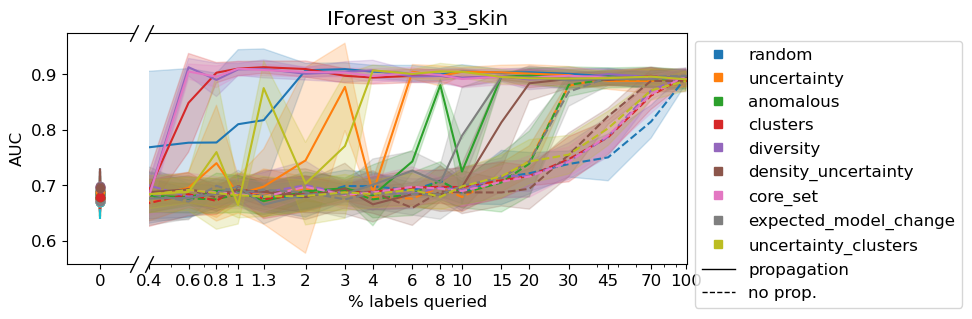

In [68]:
plot_ssalad_results(all_results, log_scale=True)